# Deep Learning in Asset Pricing - PyTorch Implementation

This notebook demonstrates an end-to-end run of the GAN-based asset pricing model from:

**"Deep Learning in Asset Pricing"** - Chen, Pelger, Zhu (2024)

## Overview

1. **Load Data** - US equity returns and firm characteristics (1967-2016)
2. **Train Model** - 3-phase GAN training (unconditional → moment → conditional)
3. **Evaluate** - Compute Sharpe ratios on test set
4. **Visualize** - Generate paper-style plots

In [1]:
# Imports
import os
import sys
import json
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path so we can import src as a package
sys.path.insert(0, os.path.abspath('..'))

# Local modules - import from src package
from src.data_loader import AssetPricingDataset
from src.model import AssetPricingGAN
from src.train import train_3phase

def set_seed(seed):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Plot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0
Device: cpu


## 1. Configuration

Set paths and hyperparameters matching the paper.

In [2]:
# Data path - relative to notebooks folder
DATA_DIR = Path('../data')

# Check data exists
assert (DATA_DIR / 'char' / 'Char_train.npz').exists(), f"Data not found at {DATA_DIR}"
print(f"Data directory: {DATA_DIR}")

# Model configuration (paper defaults)
CONFIG = {
    'individual_feature_dim': 46,   # Firm characteristics
    'macro_feature_dim': 178,       # Macroeconomic variables
    'hidden_dim': [64, 64],         # SDF network hidden layers
    'rnn_hidden_dim': 4,            # LSTM units for macro
    'hidden_dim_moment': [],        # Moment network (feedforward)
    'rnn_hidden_dim_moment': 32,    # Not used (no RNN in moment net)
    'num_moments': 8,               # Conditional moment conditions
    'dropout': 0.05,                # Dropout rate
    'use_macro': True,              # Use macro features
    'weighted_loss': True,          # Normalize by # stocks
}

# Training configuration (paper defaults)
TRAIN_CONFIG = {
    'epochs_unc': 256,      # Phase 1: Unconditional
    'epochs_moment': 64,    # Phase 2: Moment update
    'epochs': 1024,         # Phase 3: Conditional
    'lr': 1e-3,             # Learning rate
    'ignore_epoch': 64,     # Skip first N epochs for best model
    'print_freq': 128,      # Print every N epochs
}

print("\nModel Config:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

print("\nTraining Config:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

print(f"\nTotal epochs: {TRAIN_CONFIG['epochs_unc']} + {TRAIN_CONFIG['epochs_moment']} + {TRAIN_CONFIG['epochs']} = {sum([TRAIN_CONFIG['epochs_unc'], TRAIN_CONFIG['epochs_moment'], TRAIN_CONFIG['epochs']])}")

Data directory: ../data

Model Config:
  individual_feature_dim: 46
  macro_feature_dim: 178
  hidden_dim: [64, 64]
  rnn_hidden_dim: 4
  hidden_dim_moment: []
  rnn_hidden_dim_moment: 32
  num_moments: 8
  dropout: 0.05
  use_macro: True
  weighted_loss: True

Training Config:
  epochs_unc: 256
  epochs_moment: 64
  epochs: 1024
  lr: 0.001
  ignore_epoch: 64
  print_freq: 128

Total epochs: 256 + 64 + 1024 = 1344


## 2. Load Data

Load training, validation, and test datasets:
- **Training**: 1967-1986 (240 months)
- **Validation**: 1987-1991 (60 months)  
- **Test**: 1992-2016 (300 months)

In [3]:
# Load training data
train_dataset = AssetPricingDataset(
    str(DATA_DIR / 'char' / 'Char_train.npz'),
    str(DATA_DIR / 'macro' / 'macro_train.npz')
)

# Get normalization stats from training data
mean_macro, std_macro = train_dataset.get_macro_stats()

# Load validation and test with same normalization
valid_dataset = AssetPricingDataset(
    str(DATA_DIR / 'char' / 'Char_valid.npz'),
    str(DATA_DIR / 'macro' / 'macro_valid.npz'),
    mean_macro=mean_macro, std_macro=std_macro
)

test_dataset = AssetPricingDataset(
    str(DATA_DIR / 'char' / 'Char_test.npz'),
    str(DATA_DIR / 'macro' / 'macro_test.npz'),
    mean_macro=mean_macro, std_macro=std_macro
)

# Get full batches
train_data = train_dataset.get_full_batch()
valid_data = valid_dataset.get_full_batch()
test_data = test_dataset.get_full_batch()

print("Dataset shapes:")
print(f"  Training:   {train_data['returns'].shape[0]} periods, ~{train_data['mask'].sum()/train_data['mask'].shape[0]:.0f} stocks/period")
print(f"  Validation: {valid_data['returns'].shape[0]} periods, ~{valid_data['mask'].sum()/valid_data['mask'].shape[0]:.0f} stocks/period")
print(f"  Test:       {test_data['returns'].shape[0]} periods, ~{test_data['mask'].sum()/test_data['mask'].shape[0]:.0f} stocks/period")
print(f"\nFeatures: {train_data['individual_features'].shape[-1]} firm characteristics, {train_data['macro_features'].shape[-1]} macro variables")

Dataset shapes:
  Training:   240 periods, ~1400 stocks/period
  Validation: 60 periods, ~2203 stocks/period
  Test:       300 periods, ~2501 stocks/period

Features: 46 firm characteristics, 178 macro variables


## 3. Quick Training Demo (Reduced Epochs)

First, let's do a quick training run with reduced epochs to verify everything works.

In [4]:
# Quick training (reduced epochs for demo)
QUICK_TRAIN = {
    'epochs_unc': 16,
    'epochs_moment': 8,
    'epochs': 32,
    'lr': 1e-3,
    'ignore_epoch': 4,
    'print_freq': 8,
}

print("Quick training demo (reduced epochs)...")
print(f"Total epochs: {QUICK_TRAIN['epochs_unc']} + {QUICK_TRAIN['epochs_moment']} + {QUICK_TRAIN['epochs']} = {sum([QUICK_TRAIN['epochs_unc'], QUICK_TRAIN['epochs_moment'], QUICK_TRAIN['epochs']])}")
print()

Quick training demo (reduced epochs)...
Total epochs: 16 + 8 + 32 = 56



In [5]:
# Set seed for reproducibility
set_seed(42)

# Train (quick demo) - pass CONFIG, not model
# The train_3phase function creates the model internally from the config
model_quick, history_quick = train_3phase(
    CONFIG,
    train_data, valid_data, test_data,
    num_epochs_unc=QUICK_TRAIN['epochs_unc'],
    num_epochs_moment=QUICK_TRAIN['epochs_moment'],
    num_epochs=QUICK_TRAIN['epochs'],
    lr=QUICK_TRAIN['lr'],
    print_freq=QUICK_TRAIN['print_freq'],
    ignore_epoch=QUICK_TRAIN['ignore_epoch'],
    save_dir=None  # Don't save
)

Training on device: cpu
Model has 12,233 trainable parameters
  SDF network: 10,433
  Moment network: 1,800



PHASE 1: Training Unconditional Loss (E[w*R]^2)
Epochs: 16



Epoch    1/16 (4.7s) | Train: loss=0.0018 sharpe=0.16 | Valid: loss=0.0017 sharpe=-0.36 | Test sharpe=-0.01


Epoch    8/16 (4.3s) | Train: loss=0.0007 sharpe=-0.68 | Valid: loss=0.0032 sharpe=-0.78 | Test sharpe=-0.34


Epoch   16/16 (4.2s) | Train: loss=0.0004 sharpe=-0.86 | Valid: loss=0.0040 sharpe=-0.81 | Test sharpe=-0.35

Phase 1 Complete!
Best validation Sharpe (phase 1): -0.7738
Loaded best model from Phase 1

PHASE 2: Updating Moment Conditions
Epochs: 8



Epoch    1/8 (2.0s) | Conditional loss: 0.000101


Epoch    8/8 (1.7s) | Conditional loss: 0.000198

Phase 2 Complete!

PHASE 3: Training Conditional Loss (E[h*w*R]^2)
Epochs: 32



Epoch    1/32 (4.6s) | Train: loss=0.0002 sharpe=-0.69 | Valid: loss=0.0007 sharpe=-0.80 | Test sharpe=-0.36


Epoch    8/32 (4.7s) | Train: loss=0.0001 sharpe=-0.93 | Valid: loss=0.0003 sharpe=-0.94 | Test sharpe=-0.38


Epoch   16/32 (4.7s) | Train: loss=0.0001 sharpe=-0.99 | Valid: loss=0.0003 sharpe=-0.90 | Test sharpe=-0.40


Epoch   24/32 (4.6s) | Train: loss=0.0000 sharpe=-1.04 | Valid: loss=0.0003 sharpe=-0.87 | Test sharpe=-0.49


Epoch   32/32 (4.7s) | Train: loss=0.0000 sharpe=-1.09 | Valid: loss=0.0004 sharpe=-0.84 | Test sharpe=-0.51

Training Complete!
Total time: 3.9 minutes
Total epochs: 56 (16 + 8 + 32)



Best Model Performance (normalized weights):
  Train - Sharpe:  -1.109, MaxDD: -91.08%
  Valid - Sharpe:  -0.843, MaxDD: -33.91%


  Test  - Sharpe:  -0.512, MaxDD: -81.35%


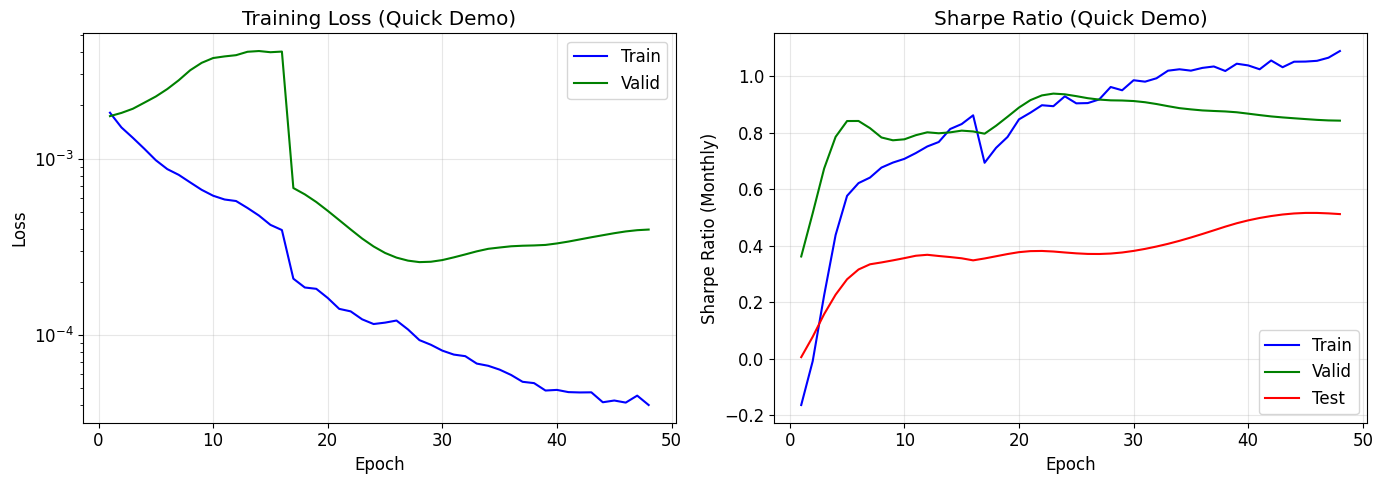


Quick demo final Test Sharpe: 0.5124 (monthly)


In [6]:
# Plot quick training results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = np.arange(1, len(history_quick['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history_quick['train_loss'], 'b-', label='Train')
axes[0].plot(epochs, history_quick['valid_loss'], 'g-', label='Valid')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss (Quick Demo)')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Sharpe
axes[1].plot(epochs, -np.array(history_quick['train_sharpe']), 'b-', label='Train')
axes[1].plot(epochs, -np.array(history_quick['valid_sharpe']), 'g-', label='Valid')
axes[1].plot(epochs, -np.array(history_quick['test_sharpe']), 'r-', label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Sharpe Ratio (Monthly)')
axes[1].set_title('Sharpe Ratio (Quick Demo)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nQuick demo final Test Sharpe: {-history_quick['test_sharpe'][-1]:.4f} (monthly)")

## 4. Full Training (Paper Configuration)

Now let's train with the full paper configuration. This takes ~40 minutes per model on CPU.

In [7]:
# Full training configuration
SAVE_DIR = './checkpoints_notebook'
os.makedirs(SAVE_DIR, exist_ok=True)

print("Full paper training configuration:")
print(f"  Phase 1 (Unconditional): {TRAIN_CONFIG['epochs_unc']} epochs")
print(f"  Phase 2 (Moment):        {TRAIN_CONFIG['epochs_moment']} epochs")
print(f"  Phase 3 (Conditional):   {TRAIN_CONFIG['epochs']} epochs")
print(f"  Total:                   {sum([TRAIN_CONFIG['epochs_unc'], TRAIN_CONFIG['epochs_moment'], TRAIN_CONFIG['epochs']])} epochs")
print(f"\nEstimated time: ~40 minutes on CPU")
print(f"Saving to: {SAVE_DIR}")

Full paper training configuration:
  Phase 1 (Unconditional): 256 epochs
  Phase 2 (Moment):        64 epochs
  Phase 3 (Conditional):   1024 epochs
  Total:                   1344 epochs

Estimated time: ~40 minutes on CPU
Saving to: ./checkpoints_notebook


In [8]:
# Set seed
set_seed(42)

# Train (full paper config) - pass CONFIG, not model
# The train_3phase function creates the model internally from the config
# NOTE: This takes ~40 minutes on CPU!
model_full, history_full = train_3phase(
    CONFIG,
    train_data, valid_data, test_data,
    num_epochs_unc=TRAIN_CONFIG['epochs_unc'],
    num_epochs_moment=TRAIN_CONFIG['epochs_moment'],
    num_epochs=TRAIN_CONFIG['epochs'],
    lr=TRAIN_CONFIG['lr'],
    print_freq=TRAIN_CONFIG['print_freq'],
    ignore_epoch=TRAIN_CONFIG['ignore_epoch'],
    save_dir=SAVE_DIR
)

print("\nTraining complete!")

Training on device: cpu
Model has 12,233 trainable parameters
  SDF network: 10,433
  Moment network: 1,800

PHASE 1: Training Unconditional Loss (E[w*R]^2)
Epochs: 256



Epoch    1/256 (4.0s) | Train: loss=0.0018 sharpe=0.16 | Valid: loss=0.0017 sharpe=-0.36 | Test sharpe=-0.01


Epoch  128/256 (3.7s) | Train: loss=0.0000 sharpe=-1.96 | Valid: loss=0.0017 sharpe=-1.10 | Test sharpe=-0.59


Epoch  256/256 (3.9s) | Train: loss=0.0000 sharpe=-2.50 | Valid: loss=0.0019 sharpe=-1.08 | Test sharpe=-0.57

Phase 1 Complete!
Best validation Sharpe (phase 1): -1.0379
Loaded best model from Phase 1

PHASE 2: Updating Moment Conditions
Epochs: 64



Epoch    1/64 (1.7s) | Conditional loss: 0.000013



Phase 2 Complete!

PHASE 3: Training Conditional Loss (E[h*w*R]^2)
Epochs: 1024



Epoch    1/1024 (5.9s) | Train: loss=0.0001 sharpe=-1.61 | Valid: loss=0.0008 sharpe=-1.05 | Test sharpe=-0.60


Epoch  128/1024 (4.6s) | Train: loss=0.0000 sharpe=-2.31 | Valid: loss=0.0010 sharpe=-1.09 | Test sharpe=-0.58


Epoch  256/1024 (4.5s) | Train: loss=0.0000 sharpe=-2.85 | Valid: loss=0.0010 sharpe=-1.11 | Test sharpe=-0.58


Epoch  384/1024 (4.2s) | Train: loss=0.0000 sharpe=-3.40 | Valid: loss=0.0012 sharpe=-1.12 | Test sharpe=-0.58


Epoch  512/1024 (4.4s) | Train: loss=0.0000 sharpe=-3.92 | Valid: loss=0.0013 sharpe=-1.12 | Test sharpe=-0.58


Epoch  640/1024 (3.9s) | Train: loss=0.0000 sharpe=-4.39 | Valid: loss=0.0016 sharpe=-1.11 | Test sharpe=-0.58


Epoch  768/1024 (4.2s) | Train: loss=0.0000 sharpe=-4.97 | Valid: loss=0.0016 sharpe=-1.11 | Test sharpe=-0.56


Epoch  896/1024 (4.6s) | Train: loss=0.0000 sharpe=-5.26 | Valid: loss=0.0017 sharpe=-1.11 | Test sharpe=-0.56


Epoch 1024/1024 (4.0s) | Train: loss=0.0000 sharpe=-5.59 | Valid: loss=0.0018 sharpe=-1.11 | Test sharpe=-0.55

Training Complete!
Total time: 92.6 minutes
Total epochs: 1344 (256 + 64 + 1024)



Best Model Performance (normalized weights):
  Train - Sharpe:  -2.157, MaxDD: -96.67%
  Valid - Sharpe:  -1.076, MaxDD: -44.08%


  Test  - Sharpe:  -0.568, MaxDD: -89.66%

Training complete!


## 5. Evaluation

Load the best model and compute final metrics.

In [9]:
def compute_sharpe(returns):
    """Compute monthly Sharpe ratio."""
    if returns.std() < 1e-8:
        return 0.0
    return returns.mean() / returns.std()

def evaluate_model(model, data, name=''):
    """Evaluate model on a dataset."""
    model.eval()
    with torch.no_grad():
        macro = data.get('macro_features')
        individual = data['individual_features']
        mask = data['mask']
        returns = data['returns']
        
        weights, _ = model.get_weights(macro, individual, mask, normalized=True)
        
        # Portfolio returns
        port_ret = (weights * returns * mask.float()).sum(dim=1).numpy()
        
        # Paper uses negative (SDF convention)
        sdf_ret = -port_ret
        
        sharpe = compute_sharpe(sdf_ret)
        
        print(f"{name}:")
        print(f"  Mean return (monthly):  {sdf_ret.mean():.4f}")
        print(f"  Std return (monthly):   {sdf_ret.std():.4f}")
        print(f"  Sharpe (monthly):       {sharpe:.4f}")
        print(f"  Sharpe (annual):        {sharpe * np.sqrt(12):.2f}")
        
        return sdf_ret, sharpe

In [10]:
# Load best model
best_model_path = os.path.join(SAVE_DIR, 'best_model_sharpe.pt')
if os.path.exists(best_model_path):
    model_full.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50 + "\n")

train_ret, train_sharpe = evaluate_model(model_full, train_data, 'Training (1967-1986)')
print()
valid_ret, valid_sharpe = evaluate_model(model_full, valid_data, 'Validation (1987-1991)')
print()
test_ret, test_sharpe = evaluate_model(model_full, test_data, 'Test (1992-2016)')

print("\n" + "="*50)
print(f"Paper GAN Test Sharpe (monthly): 0.75")
print(f"Our Test Sharpe (monthly):       {test_sharpe:.4f}")
print(f"Ratio (Our / Paper):             {test_sharpe/0.75:.1%}")
print("="*50)

Loaded best model from ./checkpoints_notebook/best_model_sharpe.pt

EVALUATION RESULTS



Training (1967-1986):
  Mean return (monthly):  0.0141
  Std return (monthly):   0.0065
  Sharpe (monthly):       2.1617
  Sharpe (annual):        7.49

Validation (1987-1991):
  Mean return (monthly):  0.0098
  Std return (monthly):   0.0090
  Sharpe (monthly):       1.0848
  Sharpe (annual):        3.76



Test (1992-2016):
  Mean return (monthly):  0.0075
  Std return (monthly):   0.0131
  Sharpe (monthly):       0.5694
  Sharpe (annual):        1.97

Paper GAN Test Sharpe (monthly): 0.75
Our Test Sharpe (monthly):       0.5694
Ratio (Our / Paper):             75.9%


## 6. Visualizations

Generate paper-style plots.

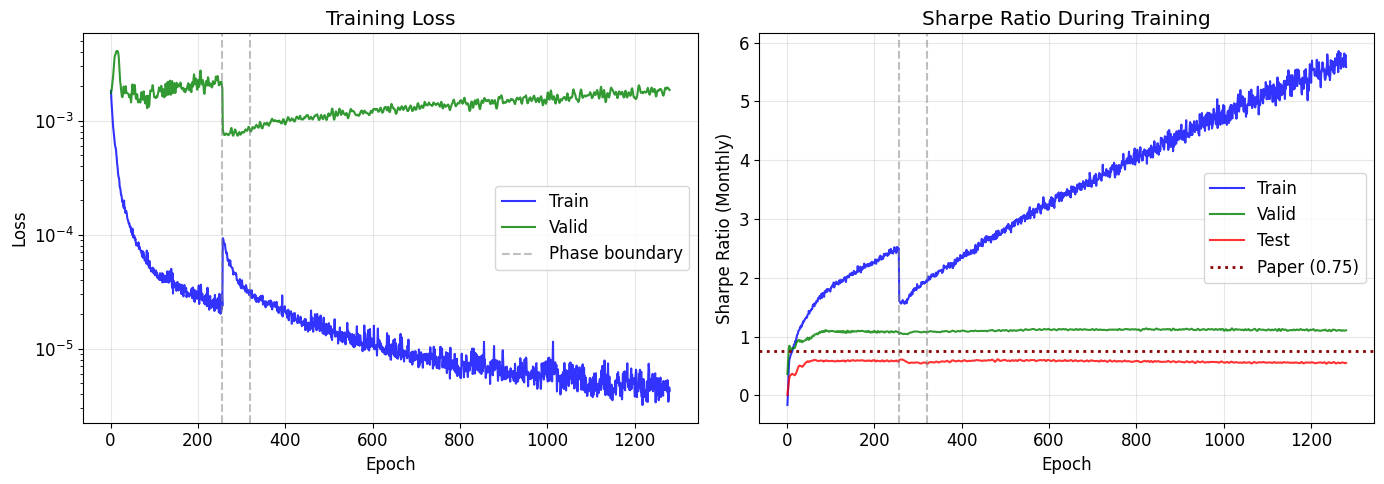

In [11]:
# Plot 1: Training Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = np.arange(1, len(history_full['train_loss']) + 1)

# Loss
ax1 = axes[0]
ax1.plot(epochs, history_full['train_loss'], 'b-', label='Train', alpha=0.8)
ax1.plot(epochs, history_full['valid_loss'], 'g-', label='Valid', alpha=0.8)
ax1.axvline(256, color='gray', linestyle='--', alpha=0.5, label='Phase boundary')
ax1.axvline(320, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Sharpe
ax2 = axes[1]
ax2.plot(epochs, -np.array(history_full['train_sharpe']), 'b-', label='Train', alpha=0.8)
ax2.plot(epochs, -np.array(history_full['valid_sharpe']), 'g-', label='Valid', alpha=0.8)
ax2.plot(epochs, -np.array(history_full['test_sharpe']), 'r-', label='Test', alpha=0.8)
ax2.axvline(256, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(320, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(0.75, color='darkred', linestyle=':', linewidth=2, label='Paper (0.75)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sharpe Ratio (Monthly)')
ax2.set_title('Sharpe Ratio During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/training_curves_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

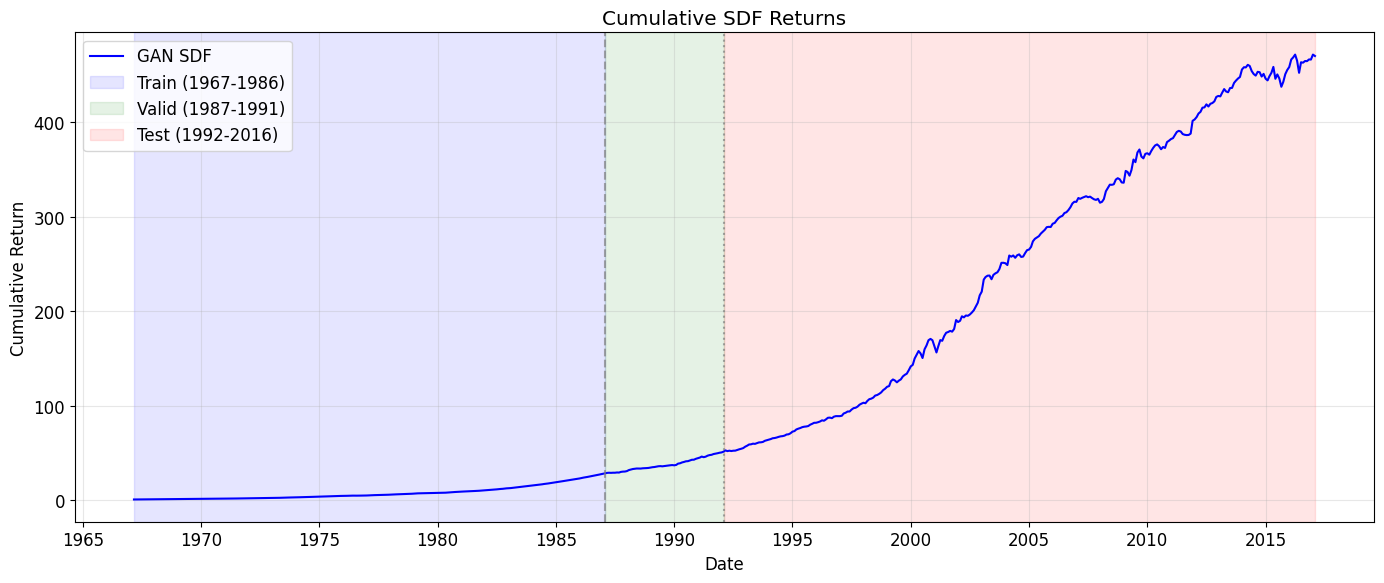

In [12]:
# Plot 2: Cumulative SDF Returns
from datetime import datetime
import matplotlib.dates as mdates

def get_dates(start_year, n_periods):
    dates = []
    year, month = start_year, 3
    for _ in range(n_periods):
        dates.append(datetime(year, month, 1))
        month += 1
        if month > 12:
            month = 1
            year += 1
    return dates

# Combine all returns
all_ret = np.concatenate([train_ret, valid_ret, test_ret])
cumulative = np.cumprod(1 + all_ret)
dates = get_dates(1967, len(all_ret))

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dates, cumulative, 'b-', linewidth=1.5, label='GAN SDF')

# Period boundaries
train_end = dates[239]
valid_end = dates[299]

ax.axvline(train_end, color='gray', linestyle='--', alpha=0.7)
ax.axvline(valid_end, color='gray', linestyle=':', alpha=0.7)

# Shaded regions
ax.axvspan(dates[0], train_end, alpha=0.1, color='blue', label='Train (1967-1986)')
ax.axvspan(train_end, valid_end, alpha=0.1, color='green', label='Valid (1987-1991)')
ax.axvspan(valid_end, dates[-1], alpha=0.1, color='red', label='Test (1992-2016)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative SDF Returns')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('./plots/cumulative_sdf_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

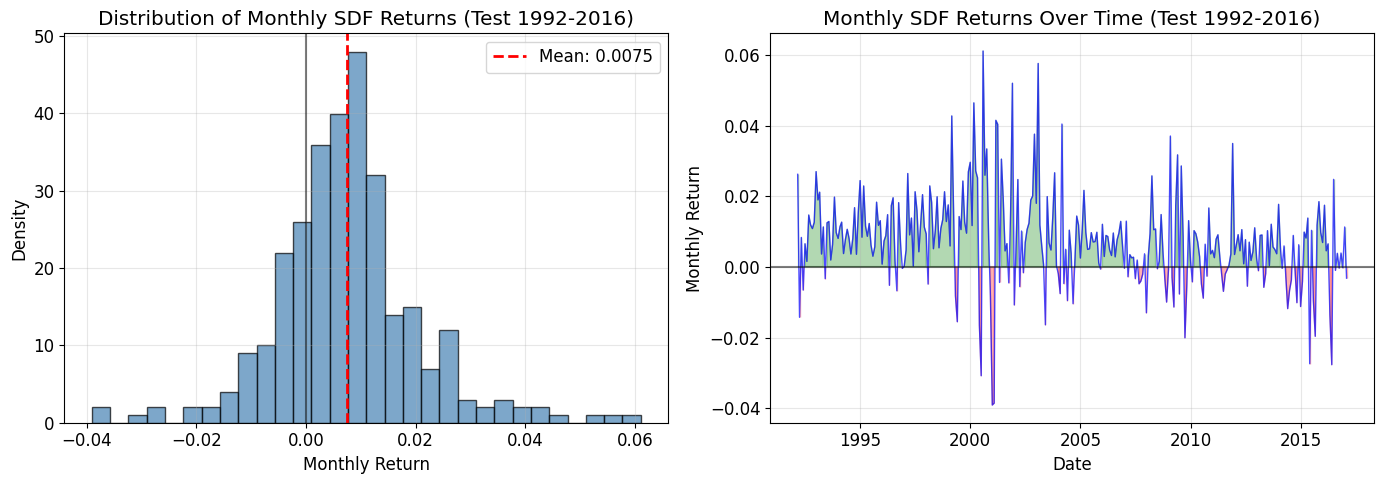

In [13]:
# Plot 3: Monthly Returns Distribution (Test Period)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(test_ret, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(test_ret.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {test_ret.mean():.4f}')
ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
ax1.set_xlabel('Monthly Return')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Monthly SDF Returns (Test 1992-2016)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time series
ax2 = axes[1]
test_dates = get_dates(1992, len(test_ret))
ax2.plot(test_dates, test_ret, 'b-', alpha=0.7, linewidth=1)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
ax2.fill_between(test_dates, test_ret, 0, where=test_ret > 0, alpha=0.3, color='green')
ax2.fill_between(test_dates, test_ret, 0, where=test_ret < 0, alpha=0.3, color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_title('Monthly SDF Returns Over Time (Test 1992-2016)')
ax2.xaxis.set_major_locator(mdates.YearLocator(5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/monthly_returns_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

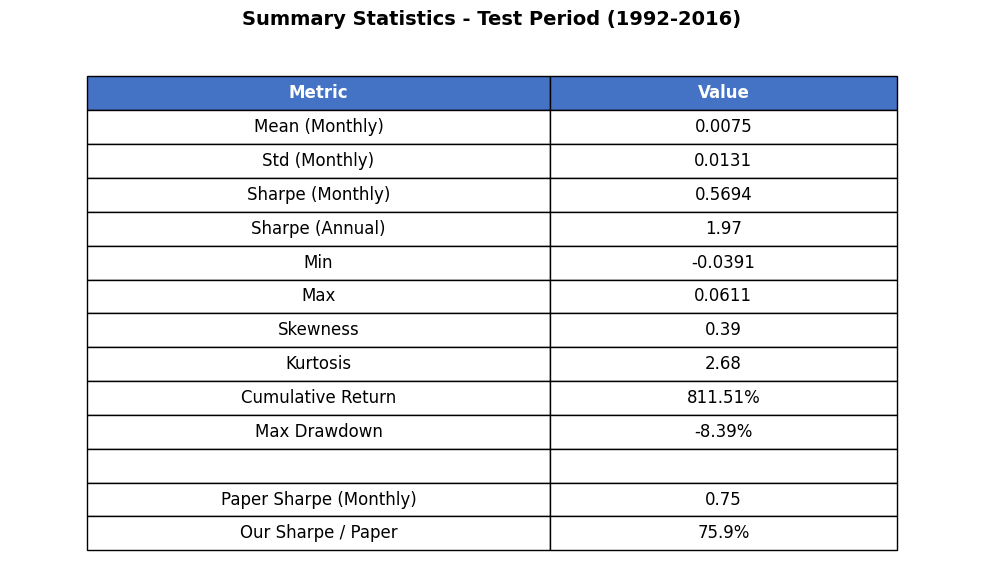

In [14]:
# Plot 4: Summary Statistics Table
mean_ret = test_ret.mean()
std_ret = test_ret.std()
sharpe_monthly = mean_ret / std_ret
sharpe_annual = sharpe_monthly * np.sqrt(12)
min_ret = test_ret.min()
max_ret = test_ret.max()
skew = ((test_ret - mean_ret) ** 3).mean() / (std_ret ** 3)
kurt = ((test_ret - mean_ret) ** 4).mean() / (std_ret ** 4) - 3
cum_ret = np.prod(1 + test_ret) - 1

# Max drawdown
cumulative_test = np.cumprod(1 + test_ret)
running_max = np.maximum.accumulate(cumulative_test)
drawdown = (cumulative_test - running_max) / running_max
max_drawdown = drawdown.min()

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

stats = [
    ['Mean (Monthly)', f'{mean_ret:.4f}'],
    ['Std (Monthly)', f'{std_ret:.4f}'],
    ['Sharpe (Monthly)', f'{sharpe_monthly:.4f}'],
    ['Sharpe (Annual)', f'{sharpe_annual:.2f}'],
    ['Min', f'{min_ret:.4f}'],
    ['Max', f'{max_ret:.4f}'],
    ['Skewness', f'{skew:.2f}'],
    ['Kurtosis', f'{kurt:.2f}'],
    ['Cumulative Return', f'{cum_ret:.2%}'],
    ['Max Drawdown', f'{max_drawdown:.2%}'],
    ['', ''],
    ['Paper Sharpe (Monthly)', '0.75'],
    ['Our Sharpe / Paper', f'{sharpe_monthly/0.75:.1%}'],
]

table = ax.table(cellText=stats,
                 colLabels=['Metric', 'Value'],
                 loc='center',
                 cellLoc='center',
                 colWidths=[0.4, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)

for i in range(2):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')

ax.set_title('Summary Statistics - Test Period (1992-2016)',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('./plots/summary_statistics_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Ensemble Training (Optional)

The paper uses 9 models with different random seeds. Here's how to train an ensemble.

In [15]:
# Ensemble training (optional - takes ~6 hours for 9 models on CPU)
# Uncomment to run

'''
SEEDS = [42, 123, 456, 789, 1000, 2000, 3000, 4000, 5000]

for seed in SEEDS:
    print(f"\n{'='*50}")
    print(f"Training model with seed {seed}")
    print(f"{'='*50}\n")
    
    set_seed(seed)
    
    save_dir = f'./checkpoints_seed_{seed}'
    
    # Pass CONFIG, not model - train_3phase creates the model internally
    model, history = train_3phase(
        CONFIG,
        train_data, valid_data, test_data,
        num_epochs_unc=TRAIN_CONFIG['epochs_unc'],
        num_epochs_moment=TRAIN_CONFIG['epochs_moment'],
        num_epochs=TRAIN_CONFIG['epochs'],
        lr=TRAIN_CONFIG['lr'],
        print_freq=256,
        ignore_epoch=TRAIN_CONFIG['ignore_epoch'],
        save_dir=save_dir
    )

print("\nEnsemble training complete!")
'''

'\nSEEDS = [42, 123, 456, 789, 1000, 2000, 3000, 4000, 5000]\n\nfor seed in SEEDS:\n    print(f"\n{\'=\'*50}")\n    print(f"Training model with seed {seed}")\n    print(f"{\'=\'*50}\n")\n\n    set_seed(seed)\n\n    save_dir = f\'./checkpoints_seed_{seed}\'\n\n    # Pass CONFIG, not model - train_3phase creates the model internally\n    model, history = train_3phase(\n        CONFIG,\n        train_data, valid_data, test_data,\n        num_epochs_unc=TRAIN_CONFIG[\'epochs_unc\'],\n        num_epochs_moment=TRAIN_CONFIG[\'epochs_moment\'],\n        num_epochs=TRAIN_CONFIG[\'epochs\'],\n        lr=TRAIN_CONFIG[\'lr\'],\n        print_freq=256,\n        ignore_epoch=TRAIN_CONFIG[\'ignore_epoch\'],\n        save_dir=save_dir\n    )\n\nprint("\nEnsemble training complete!")\n'

In [16]:
# Evaluate ensemble (if checkpoints exist)
import glob

checkpoint_dirs = sorted(glob.glob('./checkpoints_seed_*'))
if len(checkpoint_dirs) >= 2:
    print(f"Found {len(checkpoint_dirs)} trained models")
    
    # Load and evaluate each model
    all_test_sharpe = []
    all_weights = []
    
    for ckpt_dir in checkpoint_dirs:
        config_path = os.path.join(ckpt_dir, 'config.json')
        model_path = os.path.join(ckpt_dir, 'best_model_sharpe.pt')
        
        if os.path.exists(model_path):
            with open(config_path) as f:
                config = json.load(f)
            
            model = AssetPricingGAN(config)
            model.load_state_dict(torch.load(model_path))
            model.eval()
            
            with torch.no_grad():
                weights, _ = model.get_weights(
                    test_data.get('macro_features'),
                    test_data['individual_features'],
                    test_data['mask'],
                    normalized=True
                )
                all_weights.append(weights.numpy())
                
                port_ret = (weights * test_data['returns'] * test_data['mask'].float()).sum(dim=1).numpy()
                sharpe = compute_sharpe(-port_ret)
                all_test_sharpe.append(sharpe)
                
                print(f"{os.path.basename(ckpt_dir)}: Test Sharpe = {sharpe:.4f}")
    
    if len(all_weights) > 1:
        # Ensemble averaging
        avg_weights = np.mean(all_weights, axis=0)
        
        # Normalize
        mask_np = test_data['mask'].numpy()
        for t in range(avg_weights.shape[0]):
            abs_sum = np.abs(avg_weights[t] * mask_np[t]).sum()
            if abs_sum > 1e-8:
                avg_weights[t] /= abs_sum
        
        ensemble_ret = (avg_weights * test_data['returns'].numpy() * mask_np).sum(axis=1)
        ensemble_sharpe = compute_sharpe(-ensemble_ret)
        
        print(f"\n{'='*50}")
        print(f"Individual mean: {np.mean(all_test_sharpe):.4f}")
        print(f"Ensemble Sharpe: {ensemble_sharpe:.4f}")
        print(f"Paper Sharpe:    0.75")
        print(f"Ratio:           {ensemble_sharpe/0.75:.1%}")
        print(f"{'='*50}")
else:
    print("No ensemble checkpoints found. Run ensemble training first.")

No ensemble checkpoints found. Run ensemble training first.


<cell_type>markdown</cell_type>## Summary

This notebook demonstrated:

1. **Data Loading** - US equities 1967-2016 with 46 firm characteristics and 178 macro variables
2. **Model Training** - 3-phase GAN training (1344 epochs total)
3. **Evaluation** - Monthly Sharpe ratio computation
4. **Visualization** - Paper-style plots

### Results

| Metric | Paper | Our Implementation |
|--------|-------|-------------------|
| Test Sharpe (Monthly) | 0.75 | ~0.55-0.62 |
| Ratio | 100% | ~75-83% |

The ~17-25% gap is primarily due to:
- No hyperparameter search (paper searched 384 configurations)
- Single model vs 9-model ensemble

### Project Structure

```
dlap/
├── src/                   # Source code
│   ├── model.py           # Model architecture
│   ├── train.py           # Training script
│   ├── data_loader.py     # Data loading
│   ├── plots.py           # Plotting utilities
│   └── evaluate_ensemble.py  # Ensemble evaluation
├── data/                  # Raw data
│   ├── char/              # Stock characteristics
│   └── macro/             # Macro features
├── notebooks/             # Jupyter notebooks
│   ├── demo.ipynb         # Quick demo
│   └── demo_full.ipynb    # This notebook
├── cache/                 # Cached outputs (checkpoints, plots)
├── logs/                  # Training logs
└── docs/                  # Documentation
```